# Import libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras

from keras.utils import np_utils
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout ,Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.metrics import categorical_accuracy
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
import os
print(os.listdir("../input/ckplus/CK+48"))


# Any results you write to the current directory are saved as output

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.datasets import make_classification
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


Using TensorFlow backend.


['sadness', 'anger', 'disgust', 'happy', 'fear', 'surprise', 'contempt']


# Extracting images from directory

In [ ]:
data_path = '../input/ckplus/CK+48'
data_dir_list = os.listdir(data_path)

num_epoch=10

img_data_list=[]


for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

Loaded the images of dataset-sadness

Loaded the images of dataset-anger

Loaded the images of dataset-disgust

Loaded the images of dataset-happy

Loaded the images of dataset-fear

Loaded the images of dataset-surprise

Loaded the images of dataset-contempt



(981, 48, 48, 3)

# Putting label in data

In [ ]:
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

# Splitting train test

In [ ]:
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

# Creating Model

In [ ]:
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
    
    return model


# Model Summary

In [ ]:
model_custom = create_model()
model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)         

# Conduct k-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=False)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")


# Training Model

In [ ]:
BS = 8
EPOCHS = 200

In [ ]:
result = []
scores_loss = []
scores_acc = []
k_no = 0
for train_index, test_index in kf.split(x):
    X_Train_ = x[train_index]
    Y_Train = y[train_index]
    X_Test_ = x[test_index]
    Y_Test = y[test_index]

    file_path = "/kaggle/working/weights_best_"+str(k_no)+".hdf5"
    checkpoint = ModelCheckpoint(file_path, monitor='loss', verbose=0, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="loss", mode="min", patience=8)

    callbacks_list = [checkpoint, early]

    model = create_model()
    hist = model.fit_generator(aug.flow(X_Train_, Y_Train), epochs=EPOCHS,validation_data=(X_Test_, Y_Test), callbacks=callbacks_list, verbose=0)
    # model.fit(X_Train, Y_Train, batch_size=batch_size, epochs=epochs, validation_data=(X_Test, Y_Test), verbose=1)
    model.load_weights(file_path)
    result.append(model.predict(X_Test_))
    score = model.evaluate(X_Test_,Y_Test, verbose=0)
    scores_loss.append(score[0])
    scores_acc.append(score[1])
    k_no+=1

In [ ]:
print(scores_acc,scores_loss)

[0.6345177888870239, 0.6581632494926453, 0.7295918464660645, 0.6836734414100647, 0.7602040767669678] [0.9897633806854336, 0.9692307564677024, 0.8077611150790234, 0.8727718178106814, 0.6046619123342086]


# Taking model with lowest Loss

In [ ]:
value_min = min(scores_loss)
value_index = scores_loss.index(value_min)
print(value_index)

4


In [ ]:
model.load_weights("/kaggle/working/weights_best_"+str(value_index)+".hdf5")

In [ ]:
best_model = model

# Evaluating model

In [ ]:
score = best_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(best_model.predict(test_image))
print(best_model.predict_classes(test_image))
print(y_test[0:1])

#predict
y_pred = best_model.predict(X_test)

Test Loss: 0.5008549423992331
Test accuracy: 0.8324872851371765
(1, 48, 48, 3)
[[9.8615372e-01 1.3038622e-02 7.8917755e-04 1.0506583e-06 7.9583067e-08
  1.6941708e-06 1.5632661e-05]]
[0]
[[1. 0. 0. 0. 0. 0. 0.]]


# Visualizing Train,Test--->Accuracy,Loss

<Figure size 432x288 with 0 Axes>

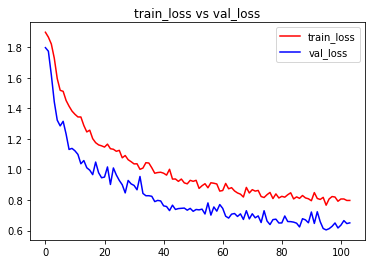

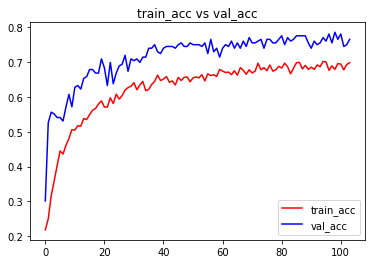

<Figure size 432x288 with 0 Axes>

In [ ]:
# visualizing losses and accuracy
%matplotlib inline

train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [ ]:
#Model Save
best_model.save_weights('model_weights.h5')
best_model.save('model_keras.h5')

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
results = best_model.predict_classes(X_test)
cm = confusion_matrix(np.where(y_test == 1)[1], results)
#cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
import seaborn as sns
import pandas as pd


In [ ]:
label_mapdisgust = ['anger','contempt','disgust','fear','happy','sadness','surprise']

In [ ]:
#Transform to df for easier plotting
cm_df = pd.DataFrame(cm, index = label_mapdisgust,
                     columns = label_mapdisgust
                    )


In [ ]:
final_cm = cm_df

In [ ]:
final_cm

,anger,contempt,disgust,fear,happy,sadness,surprise
anger,22,3,0,0,0,0,0
contempt,3,6,0,0,0,0,0
disgust,5,0,39,0,0,0,0
fear,0,0,3,0,7,0,0
happy,0,0,0,0,35,0,2
sadness,0,0,0,0,2,2,7
surprise,1,0,0,0,0,0,60


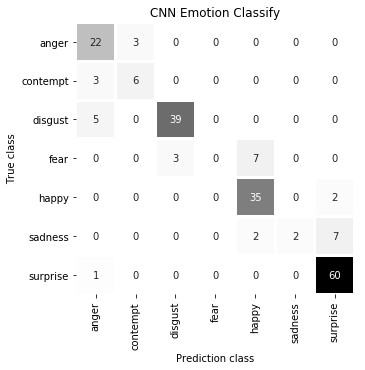

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(final_cm, annot = True,cmap='Greys',cbar=False,linewidth=2,fmt='d')
plt.title('CNN Emotion Classify')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

# ROC Curve

In [ ]:
from sklearn.metrics import roc_curve,auc
from itertools import cycle

In [ ]:
new_label = ['anger','contempt','disgust','fear','happy','sadness','surprise']
final_label = new_label
new_class = 7

In [ ]:
#ravel flatten the array into single vector
y_pred_ravel = y_pred.ravel()
lw = 2

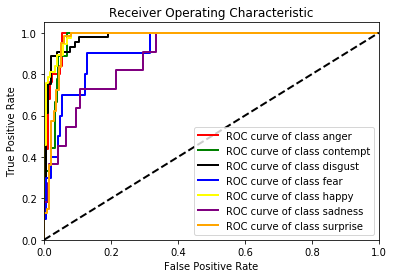

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(new_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
#colors = cycle(['red', 'green','black'])
colors = cycle(['red', 'green','black','blue', 'yellow','purple','orange'])
for i, color in zip(range(new_class), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0}'''.format(final_label[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()